In [1]:
# mindspore.dataset
import mindspore.dataset as ds # 数据集的载入
import mindspore.dataset.transforms.c_transforms as C # 常用转化算子
import mindspore.dataset.vision.c_transforms as CV # 图像转化算子

# mindspore.common
from mindspore.common import dtype as mstype # 数据形态转换
from mindspore.common.initializer import Normal # 参数初始化

# mindspore.nn
import mindspore.nn as nn # 各类网络层都在nn里面
from mindspore.nn.metrics import Accuracy # 测试模型用


from mindspore import Model # 承载网络结构


# os模块处理数据路径用
import os

# numpy
import numpy as np 


In [2]:
def create_dataset(data_path, batch_size=32):
    """ 
    数据预处理与批量输出的函数
    
    Args:
        data_path: 数据路径
        batch_size: 批量大小
    """
    
    # 定义数据集
    data = ds.MnistDataset(data_path)
    
    # 打乱数据集
    data = data.shuffle(buffer_size=10000)
    
    # 数据标准化参数
    # MNIST数据集的 mean = 33.3285，std = 78.5655
    mean, std = 33.3285, 78.5655 

    # 定义算子
    nml_op = lambda x : np.float32((x-mean)/std) # 数据标准化，image = (image-mean)/std
    hwc2chw_op = CV.HWC2CHW() # 通道前移（为配适网络，CHW的格式可最佳发挥昇腾芯片算力）
    type_cast_op = C.TypeCast(mstype.int32) # 原始数据的标签是unint，计算损失需要int

    # 算子运算
    data = data.map(operations=type_cast_op, input_columns='label')
    data = data.map(operations=nml_op, input_columns='image')
    data = data.map(operations=hwc2chw_op, input_columns='image')

    # 批处理
    data = data.batch(batch_size)
    
    # 重复
    data = data.repeat(1)

    return data 


In [3]:
class LeNet5(nn.Cell):
    
    # 定义算子
    def __init__(self, num_class=10, num_channel=1):
        super(LeNet5, self).__init__()
        # 卷积层
        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        
        # 全连接层
        self.fc1 = nn.Dense(4 * 4 * 16, 120, weight_init=Normal(0.02))
        self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
        self.fc3 = nn.Dense(84, num_class, weight_init=Normal(0.02))
        
        # 激活函数
        self.relu = nn.ReLU()
        
        # 最大池化层
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 网络展开
        self.flatten = nn.Flatten()
        
    # 建构网络
    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x 


In [4]:
train_path = os.path.join('./minst','train') # 训练集路径
train_data = create_dataset(train_path) # 定义训练数据集

test_path = os.path.join('./minst','rtest') # 测试集路径
test_data = create_dataset(test_path) # 定义测试数据集 


In [5]:
# 网络
net = LeNet5()

# 损失函数
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')

# 优化器
lr = 0.01
momentum = 0.9
net_opt = nn.Momentum(net.trainable_params(), lr, momentum)

# 模型
model = Model(net, net_loss, net_opt, metrics={'accuracy': Accuracy()}) 


In [6]:
model.train(1, train_data) # 训练3个epoch 
model.eval(test_data,dataset_sink_mode=False)

{'accuracy': 0.9491}

In [7]:
model.train(1, train_data) # 训练3个epoch 
model.eval(test_data,dataset_sink_mode=False)

{'accuracy': 0.9773}

In [10]:
model.train(1, train_data)
model.eval(test_data,dataset_sink_mode=False)

{'accuracy': 0.9846}

In [11]:
model.train(1, train_data)
model.eval(test_data,dataset_sink_mode=False)

{'accuracy': 0.9838}

In [12]:
model.train(1, train_data)
model.eval(test_data,dataset_sink_mode=False)

{'accuracy': 0.9837}

Text(0, 0.5, 'acc')

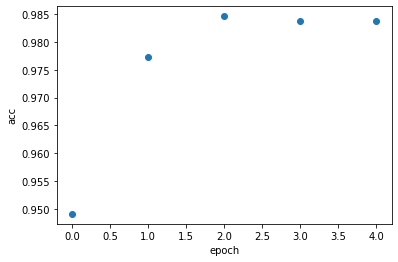

In [13]:
acc=[0.9491,0.9773,0.9846,0.9838,0.9837]
import matplotlib.pyplot as plt
plt.scatter(range(len(acc)),acc)
plt.xlabel("epoch")
plt.ylabel("acc")